In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.show()
    
    return fig

In [5]:


def loadImages(path_data, path_labels):

    image_list = []
    

    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = path_labels    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [7]:
train_data = '/home/jovyan/DATA_MASTER_PROJECT/A549/Prof_of_concept/trained_cropped/*.tiff'
train_lab='/home/jovyan/DATA_MASTER_PROJECT/A549/Prof_of_concept/train_labels.csv'


test_data='/home/jovyan/DATA_MASTER_PROJECT/A549/Prof_of_concept/test_cropped/*.tiff'
test_lab='/home/jovyan/DATA_MASTER_PROJECT/A549/Prof_of_concept/test_leb.csv'

# Train and Validation set

In [8]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages(train_data, train_lab))
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 3171.50it/s]


((7592, 90, 90, 3), (7592,))

In [9]:
x_orig_1 = x_orig_1/255


In [10]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((6073, 90, 90, 3), (1519, 90, 90, 3), (6073,), (1519,))

# Test set

In [11]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

KeyboardInterrupt: 

In [ ]:
x_test = x_test/255

In [ ]:
#Show n rabdom images to check for quality

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_1[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[y_orig_1[i]])
plt.show()

In [ ]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

In [ ]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

In [ ]:
input_shape = (90,90,3)

In [ ]:
m = Sequential()
m.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape))
m.add(MaxPooling2D())

m.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Flatten())

m.add(Dense(128, activation='relu'))


m.add(Dense(3,activation='sigmoid'))
m.summary()

In [ ]:
m.compile(loss= binary_crossentropy,
              optimizer = Adam(lr=1e-4),
             metrics = ['accuracy'])


In [ ]:

epochs = 100

m_h = m.fit(x_train_1, y_train_1,
            epochs=epochs, 
            callbacks = [es],
            class_weight = weights,
            validation_data=(x_val, y_val))

In [ ]:
plot_history(m_h, 'first')

In [64]:
scores = m.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

976/976 [==============================] - 0s 140us/sample - loss: 0.6552 - accuracy: 0.6240

accuracy: 62.40%


In [65]:
test_preds = m.predict(x_test)

In [66]:
t= []
for i in (test_preds):
    if i > 0.5:
        t.append(1)
    else:
        t.append(0)

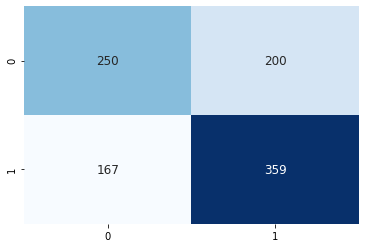

array([[250, 200],
       [167, 359]])

In [67]:
draw_confusion_matrix(y_test, t)

In [68]:
print(classification_report(y_test, t))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       450
           1       0.64      0.68      0.66       526

    accuracy                           0.62       976
   macro avg       0.62      0.62      0.62       976
weighted avg       0.62      0.62      0.62       976

